In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.insert(1, '/Users/kunalchakraborty/Downloads/Appian/appianway/')

In [203]:
import econometrics

In [200]:
%reload_ext autoreload
%autoreload 2

In [117]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-117-1390d13c0cdd>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Trade identified pairs

In [5]:
data_path = "/Users/kunalchakraborty/Downloads/Appian/data"
df = pd.read_csv(econometrics.get_data(data_path, "main_data.csv"))

In [8]:
performance_df = pd.read_csv(econometrics.get_data(data_path, "rahul_pair_performance.csv"))

In [7]:
## Trade individual pairs
rahul_pair = [('FB', 'GOOG'),
 ('KBH', 'TOL'),
 ('DHI', 'LEN'),
 ('CL', 'PG'),
 ('HAL', 'SLB'),
 ('CVX', 'XOM'),
 ('CSX', 'NSC'),
 ('ITT', 'PH'),
 ('TKR', 'URI'),
 ('RTX', 'WWD'),
 ('LRCX', 'MKSI'),
 ('ADI', 'MCHP'),
 ('QRVO', 'SWKS'),
 ('IP', 'WRK'),
 ('CE', 'EMN'),
 ('CDE', 'HL'),
 ('NUE', 'STLD'),
 ('CC', 'TROX'),
 ('IVV', 'SPY'),
 ('IWF', 'VUG'),
 ('RYN', 'WY')]

In [11]:
X = econometrics.normalize_price(econometrics.extract_time_series(df, "IVV","5. adjusted close", "2019-01-01","2021-07-31"))
Y = econometrics.normalize_price(econometrics.extract_time_series(df, "SPY","5. adjusted close", "2019-01-01","2021-07-31"))

indicator_series = performance_df[performance_df["pair"]=="IVV~SPY"][["end_date", "is_coint"]].set_index("end_date")

In [58]:
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
def plot_triple_curves(S1,S2, S3,xlabel, ylabel, zlabel, S1_label, S2_label, S3_label):
    fig, host = plt.subplots(figsize=(18,5)) # (width, height) in inches
    
    common_datelist = econometrics.get_common_dates(S2,S3)
    S1 = S1[S1.index.isin(common_datelist)]
    S2 = S2[S2.index.isin(common_datelist)]
    S3 = S3[S3.index.isin(common_datelist)]

    par1 = host.twinx()
    par2 = host.twinx()
    

    host.set_xlabel(xlabel)
    host.set_ylabel(S3_label)
    par1.set_ylabel(S1_label)
    par2.set_ylabel(S2_label)

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    p1, = host.plot(S3.index, S3.values, color=color1, label=S3_label)
    p2, = par1.plot(S1.index, S1.values, color=color2, label=S1_label)
    p3, = par2.plot(S2.index, S2.values, color=color3, label=S2_label)

    lns = [p1, p2, p3]
    host.legend(handles=lns, loc='best')

In [160]:
X_norm = econometrics.normalize_price(econometrics.extract_time_series(df, "ADI","5. adjusted close", "2021-03-01","2021-07-31"))
Y_norm = econometrics.normalize_price(econometrics.extract_time_series(df, "MCHP","5. adjusted close", "2021-03-01","2021-07-31"))

X = econometrics.extract_time_series(df, "ADI","5. adjusted close", "2021-03-01","2021-07-31")
Y = econometrics.extract_time_series(df, "MCHP","5. adjusted close", "2021-03-01","2021-07-31")
indicator_series = performance_df[performance_df["pair"]=="ADI~MCHP"][["end_date", "is_coint"]].set_index("end_date")

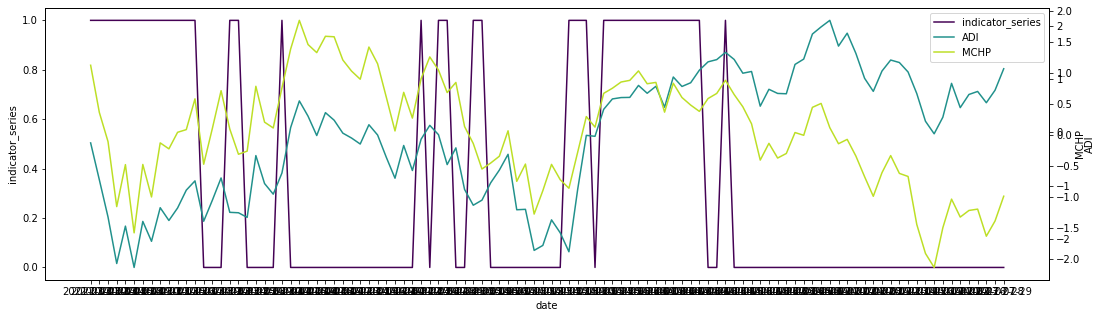

In [161]:
plot_triple_curves(X_norm,Y_norm,indicator_series, "date", "price1", "price2", "ADI", "MCHP","indicator_series")

## Forecast using different methodologies

### Experiment with pairs ADI and MCHP

Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


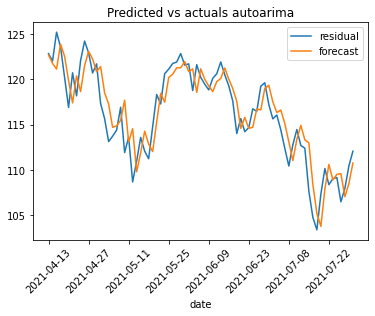

In [169]:
residual_series = econometrics.get_stationary_series(Y,X)
forecasted_deviations = econometrics.rolling_window_single_series_forecast(residual_series,30)
econometrics.plot_common_series(residual_series, forecasted_deviations, "Predicted vs actuals autoarima","residual", "forecast")

In [170]:
differenced_series = econometrics.get_difference_series(residual_series, forecasted_deviations)

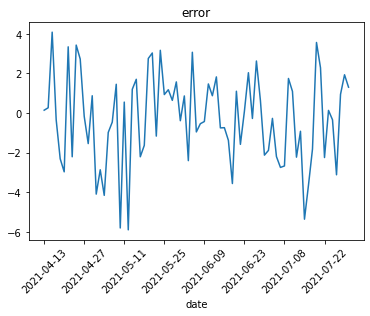

In [171]:
econometrics.plot_individual_series(differenced_series,title="error")

In [172]:
top_strategy, bottom_strategy, datelist = generate_mad_signals(differenced_series,2,0,window=30)

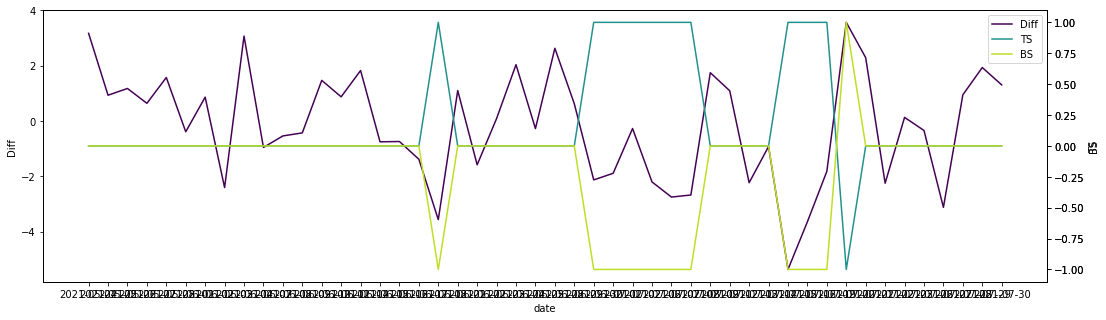

In [173]:
plot_triple_curves(pd.Series(top_strategy, index=datelist), 
                   pd.Series(bottom_strategy, index=datelist), differenced_series, "date", "indicator", "p diff", "TS", "BS","Diff")

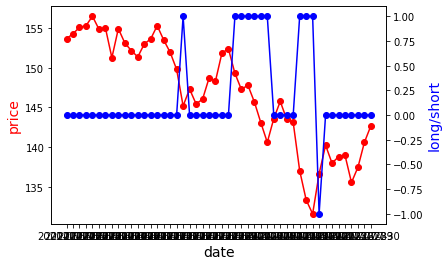

In [174]:
econometrics.plot_twin_axis(Y, pd.Series(top_strategy, index=datelist),"price","long/short")

In [175]:
lp, sp = compute_profits(Y, X, top_strategy, bottom_strategy, datelist, cointegrating_series = "Y")
print("Profit from long position = ", lp)
print("Profit from short position = ", sp)

print("Total profit from static hedges = ", lp + sp)

Profit from long position =  -4.127522554344907
Profit from short position =  32.07774828799995
Total profit from static hedges =  27.950225733655046


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=182.924, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=164.123, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=174.907, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=361.152, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=164.174, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=164.760, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=164.222, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.198 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=183.129, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=162.482, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=174.029, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=361.162, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=161.850, Time=0.04 

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=153.319, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.188 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=163.820, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=147.424, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=151.624, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=362.584, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=149.113, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=148.627, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=150.974, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.215 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=159.337, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=144.419, Ti

 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=147.761, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=148.354, Time=0.03 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 0.643 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=180.416, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=144.381, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=165.709, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=361.657, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=145.706, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=145.855, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=145.365, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.225 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=180.664, Ti

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=142.466, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.170 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=172.108, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=138.397, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=156.900, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=360.759, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=140.073, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=140.195, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=141.276, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.218 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=171.901, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=139.612, Ti

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=132.763, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=134.702, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.349 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=165.127, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=127.019, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=148.884, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=361.019, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=129.060, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=129.022, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=130.596, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.252 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=159.491, Ti

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=125.205, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.252 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=152.380, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=120.618, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=134.176, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=360.751, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=122.489, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=122.520, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=124.550, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.200 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=152.686, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.157, Ti

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=134.394, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=133.997, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=134.033, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.226 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=170.732, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=132.885, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=358.233, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=134.126, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=134.010, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=134.683, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.188 seconds
Performing stepwise search to minim

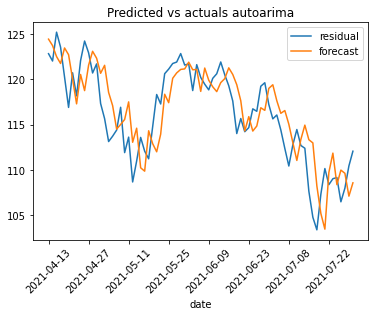

In [176]:
## Checking autoarima
forecasted_deviations = econometrics.rolling_window_single_series_forecast(residual_series,30,"auto_arima")
econometrics.plot_common_series(residual_series, forecasted_deviations, "Predicted vs actuals autoarima","residual", "forecast")

In [177]:
## Need series diff
## Compute deviations
differenced_series = econometrics.get_difference_series(residual_series, forecasted_deviations)

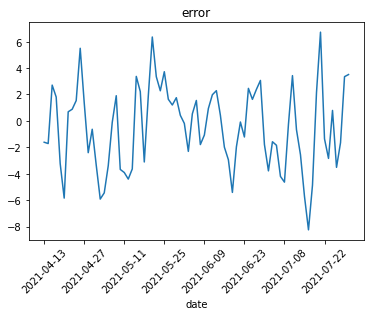

In [178]:
econometrics.plot_individual_series(differenced_series,title="error")

In [179]:
top_strategy, bottom_strategy, datelist = generate_mad_signals(differenced_series,2,0,window=30)

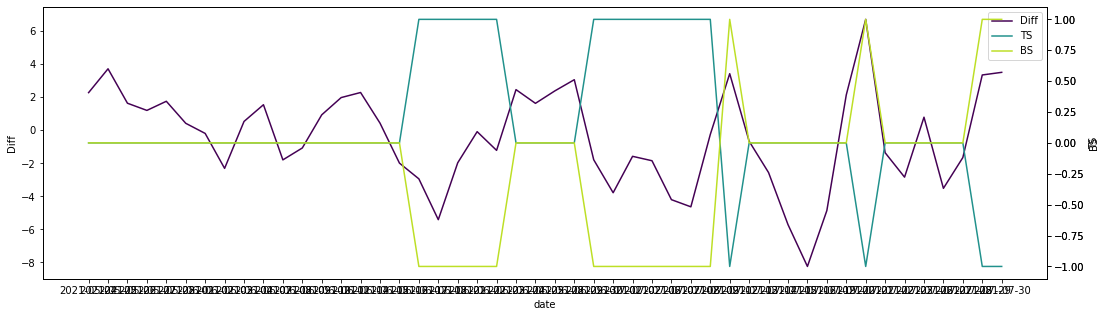

In [180]:
plot_triple_curves(pd.Series(top_strategy, index=datelist), 
                   pd.Series(bottom_strategy, index=datelist), differenced_series, "date", "indicator", "p diff", "TS", "BS","Diff")

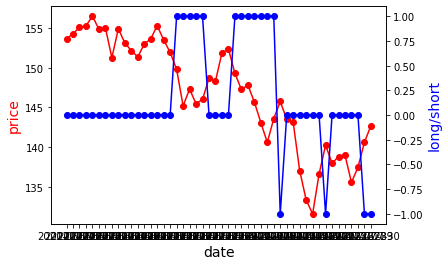

In [181]:
econometrics.plot_twin_axis(Y, pd.Series(top_strategy, index=datelist),"price","long/short")

In [182]:
lp, sp = compute_profits(Y, X, top_strategy, bottom_strategy, datelist, cointegrating_series = "Y")
print("Profit from long position = ", lp)
print("Profit from short position = ", sp)
print("Total profit from static hedges = ", lp + sp)

Profit from long position =  -3.9108069414699407
Profit from short position =  37.42569949399996
Total profit from static hedges =  33.514892552530014


In [208]:
def trade_pair_portfolio(df, y_ticker, x_ticker, start_date, end_date, forecasting_args, historical_beta = {}):
    """The start date has to be carefully passed so that coincides with the entry point the of trading horizon"""
    X = econometrics.extract_time_series(df, x_ticker, "5. adjusted close", start_date, end_date)
    Y = econometrics.extract_time_series(df, y_ticker, "5. adjusted close", start_date, end_date)
    common_datelist = econometrics.get_common_dates(X,Y)
    X = X[X.index.isin(common_datelist)]
    Y = Y[Y.index.isin(common_datelist)]
    # Get residual portfolio
    residual_series, coint_tick = econometrics.get_stationary_series(Y,X)
    # Perform forecasting
    forecasted_deviations = econometrics.rolling_window_single_series_forecast(residual_series,
                                                                               forecasting_args["forecasting_horizon"])
    differenced_series = econometrics.get_difference_series(residual_series, forecasted_deviations)
    # Perform MAD deviation computation
    top_strategy, bottom_strategy, datelist = econometrics.generate_mad_signals(differenced_series, 
                                                                   forecasting_args["entry_threshold"], 
                                                                   forecasting_args["exit_threshold"], forecasting_args["mad_train_horizon"])
    # Compute profits
    
    lp, sp = econometrics.compute_profits(Y, X, top_strategy, bottom_strategy, 
                             datelist, coint_tick, historical_beta)
    
    final_df = {}
    final_df["long_profit"] = [lp]
    final_df["short_profit"] = [sp]
    final_df["total_profit"] = [lp+sp]
    return final_df

In [209]:
pair_portfolio = [("ADI", "MCHP"), ("CL", "PG")]

In [231]:
## Trade individual pairs
pair_portfolio = [
 ('DHI', 'LEN'),
 ('HAL', 'SLB'),
 ('CVX', 'XOM'),
 ('CSX', 'NSC'),
 ('ITT', 'PH'),
 ('LRCX', 'MKSI'),
 ('ADI', 'MCHP'),
 ('IP', 'WRK'),
 ('CDE', 'HL'),
 ('NUE', 'STLD'),
 ('IVV', 'SPY'),
 ('IWF', 'VUG'),
 ('RYN', 'WY')]

In [232]:
## Create a portfolio of pair of stocks

## Step 1: Select start date and training period.
start_date = "2019-01-01"
training_period_length = 180
trading_period_length = 60
mad_training_horizon = 30
forecasting_horizon = 30
mega_datelist = sorted(df["date"].unique().tolist())
closest_date = econometrics.find_closest_date(start_date, mega_datelist)
start_index = mega_datelist.index(closest_date)
portfolio_list = []
forecasting_args = {"entry_threshold":2.5, "exit_threshold":0,"method":"auto_arima",
                    "mad_train_horizon":mad_training_horizon,"forecasting_horizon":forecasting_horizon}
for index in range(start_index, len(mega_datelist), training_period_length + trading_period_length):
    ## Step1: extract the series upto training horizon
    start_date = mega_datelist[index]
    end_date = mega_datelist[index + training_period_length]
    start_date_trading = mega_datelist[index - 
                                       (mad_training_horizon + forecasting_horizon) + training_period_length]
    
    end_date_trading = mega_datelist[index - (mad_training_horizon + forecasting_horizon) 
                                     + trading_period_length + training_period_length]
    
    for pair in pair_portfolio:
        print("Date = {}, pair = {}".format(start_date, pair))
        y_ticker = pair[0]
        x_ticker = pair[1]
        X = econometrics.extract_time_series(df, x_ticker, "5. adjusted close", start_date, end_date)
        Y = econometrics.extract_time_series(df, y_ticker, "5. adjusted close", start_date, end_date)
        # Estimate historical betas
        historical_beta = {"X": np.cov(Y,X)[0][1]/np.var(X), "Y" : np.cov(Y,X)[0][1]/np.var(Y)}
        # Estimate profit
        profit_dict = trade_pair_portfolio(df, y_ticker, x_ticker, start_date_trading, end_date_trading, 
                                           forecasting_args, historical_beta = historical_beta)
        
        profit_dict["trading_begin"] = start_date_trading
        profit_dict["trading_end"] = end_date_trading
        profit_dict["pairs"] = y_ticker + "~" + x_ticker
        
        portfolio_list.append(pd.DataFrame(profit_dict))
        print("Profit computation complete")

Date = 2018-12-31, pair = ('DHI', 'LEN')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0
Profit computation complete
Date = 2018-12-31, pair = ('HAL', 'SLB')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0
Profit computation complete
Date = 2018-12-31, pair = ('CVX', 'XOM')
Co-integration series = X
0
Profit computation complete
Date = 2018-12-31, pair = ('CSX', 'NSC')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0
Profit computation complete
Date = 2018-12-31, pair = ('ITT', 'PH')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2018-12-31, pair = ('LRCX', 'MKSI')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0
Profit computation complete
Date = 2018-12-31, pair = ('ADI', 'MCHP')
Co-integration series = X
0
Profit computation complete
Date = 2018-12-31, pair = ('IP', 'WRK')
Co-integration series = X
0
Profit computation complete
Date = 2018-12-31, pair = ('CDE', 'HL')
Co-integration series = X
0
Profit computation complete
Date = 2018-12-31, pair = ('NUE', 'STLD')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0
Profit computation complete
Date = 2018-12-31, pair = ('IVV', 'SPY')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2018-12-31, pair = ('IWF', 'VUG')
Co-integration series = Y
0
Profit computation complete
Date = 2018-12-31, pair = ('RYN', 'WY')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0
Profit computation complete
Date = 2019-12-12, pair = ('DHI', 'LEN')
Co-integration series = X
0
Profit computation complete
Date = 2019-12-12, pair = ('HAL', 'SLB')
Co-integration series = Y
0
Profit computation complete
Date = 2019-12-12, pair = ('CVX', 'XOM')
Co-integration series = Y
0
Profit computation complete
Date = 2019-12-12, pair = ('CSX', 'NSC')
Co-integration series = X
0
Profit computation complete
Date = 2019-12-12, pair = ('ITT', 'PH')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2019-12-12, pair = ('LRCX', 'MKSI')
Co-integration series = X
0
Profit computation complete
Date = 2019-12-12, pair = ('ADI', 'MCHP')
Co-integration series = Y
0
Profit computation complete
Date = 2019-12-12, pair = ('IP', 'WRK')
Co-integration series = X
0
Profit computation complete
Date = 2019-12-12, pair = ('CDE', 'HL')
Co-integration series = X
0
Profit computation complete
Date = 2019-12-12, pair = ('NUE', 'STLD')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2019-12-12, pair = ('IVV', 'SPY')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2019-12-12, pair = ('IWF', 'VUG')
Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2019-12-12, pair = ('RYN', 'WY')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('DHI', 'LEN')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('HAL', 'SLB')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('CVX', 'XOM')
Co-integration series = Y
0
Profit computation complete
Date = 2020-11-24, pair = ('CSX', 'NSC')
Co-integration series = Y
0
Profit computation complete
Date = 2020-11-24, pair = ('ITT', 'PH')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2020-11-24, pair = ('LRCX', 'MKSI')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('ADI', 'MCHP')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('IP', 'WRK')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('CDE', 'HL')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('NUE', 'STLD')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('IVV', 'SPY')
Co-integration series = Y


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
Profit computation complete
Date = 2020-11-24, pair = ('IWF', 'VUG')
Co-integration series = X
0
Profit computation complete
Date = 2020-11-24, pair = ('RYN', 'WY')
Co-integration series = Y
0
Profit computation complete


In [233]:
portfolio = pd.concat(portfolio_list).sort_values("pairs")

In [234]:
portfolio

,long_profit,short_profit,total_profit,trading_begin,trading_end,pairs
0,-3.539578,-0.810998,-4.350576,2020-06-05,2020-08-31,ADI~MCHP
0,1.493841,0.283413,1.777254,2021-05-19,2021-08-13,ADI~MCHP
0,1.231663,-0.215951,1.015712,2019-06-24,2019-09-18,ADI~MCHP
0,0.090000,0.065843,0.155843,2021-05-19,2021-08-13,CDE~HL
0,-0.060000,-0.060326,-0.120326,2019-06-24,2019-09-18,CDE~HL
0,0.110000,0.142281,0.252281,2020-06-05,2020-08-31,CDE~HL
0,-0.009749,0.168340,0.158591,2019-06-24,2019-09-18,CSX~NSC
0,-2.556752,-0.090000,-2.646752,2021-05-19,2021-08-13,CSX~NSC
0,-0.201012,0.000000,-0.201012,2020-06-05,2020-08-31,CSX~NSC
0,0.000000,0.000000,0.000000,2019-06-24,2019-09-18,CVX~XOM


In [235]:
portfolio["total_profit"].sum()

-34.49813557904217

In [236]:
portfolio.sort_values("total_profit")

,long_profit,short_profit,total_profit,trading_begin,trading_end,pairs
0,-14.285304,-6.664331,-20.949634,2020-06-05,2020-08-31,LRCX~MKSI
0,-3.539578,-0.810998,-4.350576,2020-06-05,2020-08-31,ADI~MCHP
0,-1.688730,-1.624496,-3.313226,2021-05-19,2021-08-13,ITT~PH
0,-3.100000,0.000000,-3.100000,2021-05-19,2021-08-13,LRCX~MKSI
0,-2.556752,-0.090000,-2.646752,2021-05-19,2021-08-13,CSX~NSC
0,-1.217786,-1.295678,-2.513464,2020-06-05,2020-08-31,ITT~PH
0,-1.119855,-0.699429,-1.819285,2020-06-05,2020-08-31,CVX~XOM
0,-0.516463,-1.003872,-1.520335,2020-06-05,2020-08-31,NUE~STLD
0,-0.465633,-0.997897,-1.463530,2020-06-05,2020-08-31,DHI~LEN
0,-0.592992,-0.580000,-1.172992,2021-05-19,2021-08-13,CVX~XOM


In [238]:
portfolio.groupby("pairs")["total_profit"].sum().sort_values()

pairs
LRCX~MKSI   -23.479247
ITT~PH      -6.094797 
CVX~XOM     -2.992277 
CSX~NSC     -2.689174 
IP~WRK      -2.678251 
ADI~MCHP    -1.557611 
HAL~SLB     -1.211057 
NUE~STLD    -0.825681 
RYN~WY      -0.546303 
CDE~HL       0.287798 
DHI~LEN      1.288064 
IVV~SPY      2.324638 
IWF~VUG      3.675761 
Name: total_profit, dtype: float64